<table align="right" width=100%>
    <tr>
        <td width="20%">
            <img src="hcg-logo.png">
        </td>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                  <b> CAPSTONE PROJECT DSE </b> 
                </font>
            </div>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> Home Credit Part 4: Model Evaluation & Tuning (DATASET 2)</b>
                </font>
             </div>
        </td>
    </tr>
</table>

# Welcome to Final Part of the Home Credit Capstone Project 

By now we have managed to extract 57 new features from the additional tables provided to us by home credit and also we handled the null values in our dataset by creating two different datasets and finally generated two new CSV files:
- application_data_cleaned_1.csv
- application_data_cleaned_2.csv

Further in Part 2 we tackled our next challenge to further enhance our data and prepare it for ML models. We simplified categorical features, transformed highly skewed numerical features, scaled them and created dummy for categorical features.

Finally, we created a Logistice Regression base model which currently sits at 0.75 ROC_AUC score.

Therefore, in this notebook, we aim to further enhance the performance of our model using various methods laid down below:

- 

<a id="home"></a>
## Table of Content (...in continuation)

- **[Import Libraries](#lib)**

- **[Creating Functions for Ease of Coding](#func)**


10. **[Fitting Models on the Final Reduced Dataset 2](#reduced)**
    - 10.1 - **[Logistic Regression Final Model](#logreg)**
    - 10.2 - **[Decision Tree Final Model](#dt)**
    - 10.3 - **[RandomForrest Final Model](#rf)**
    - 10.4 - **[XGBoost Final Model](#xgb)**
    - 10.5 - **[LGBoost Final Model](#lgb)**
    - 10.6 - **[Reduced Models Performance Summary](#summary)**
        
11. **[Using Stratified KFold Sampling on LGBM Classifier To Increase Performance](#kfold)**

12. **[Using SMOTE To Increase Performance](#smote)**

13. **[Final Feature Importance from Best Classifier](#feat_imp)**

14. **[Hyperparameter Tuning for the Best Classifier](#tuning)**

In [3]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore') 

#for displaying max columns
pd.pandas.set_option('display.max_columns', None)

## For Smote
from imblearn.over_sampling import SMOTE


# import train-test split 
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score,recall_score

# For oversampling
from imblearn.over_sampling import SMOTE

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import gc
import time

# Loading Final Dataset 2

In [4]:
df=pd.read_csv('scaled_df2_final.csv')

In [5]:
df= df.drop('Unnamed: 0',axis=1)

In [6]:
df.head()

,TARGET,EXT_SOURCE_3,PAYMENT_RATE,EXT_SOURCE_2,PERCENT_ON_TIME_INSTALLMENTS,YEARS_BIRTH,ANNUITY_INCOME_RATIO,AVG_CNT_PAYMENT,GOODS_CREDIT_RATIO,AVG_AMT_ANNUITY,YEARS_REGISTRATION,YEARS_EMPLOYED,YEARS_ID_PUBLISH,TOTAL_CUSTOMER_CREDIT,STD_CNT_PAYMENT,YEARSDAYS_DECISION_prev,APARTMENTS_MODE,TOTAL_INSTALLMENTS,YEARS_LAST_PHONE_CHANGE,DEBT_PERCENT,YEARS_BUILD_MODE,GOODS_INCOME_RATIO,INCOME_PER_PERSON,AMT_INCOME_TOTAL,STD_AMT_ANNUITY,PERCENT_POS_Completed,OBS_30_CNT_SOCIAL_CIRCLE,prev_status_Refused,YEARSDAYS_DIFF,TOTAL_BUREAU_ACCOUNTS,CODE_GENDER_M,PERCENT_CREDIT_ACTIVE,AVG_CREDIT_LIMIT,YIELD_GROUP_low,FLAG_DOCUMENT_SUM,HOUR_APPR_PROCESS_START,PERCENT_DURATION_STATUS_CLOSED,prev_POS,PERCENT_ConsumerCredit_CREDIT_TYPE,PERCENT_AVAILED_INSURANCE,ENTRANCES_MODE,ELEVATORS_AVG,YIELD_GROUP_high,PERCENT_ON_TIME_PAYMENT_BUREAU,NAME_EDUCATION_TYPE_Secondary_Education,AMT_REQ_CREDIT_BUREAU_QRT,TOTAL_CUSTOMER_OVERDUE,prev_Unaccompanied,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,-2.106914,-0.607326,-1.433449,0.344187,-1.527562,-0.338249,1.079149,-0.317852,-0.283153,-0.439798,-0.431942,-0.589855,0.102203,-1.224628,-0.429026,-1.145165,-0.321713,0.162285,0.527153,-0.224283,-0.636371,1.830685,0.414227,-1.247628,-1.815062,0.747497,-0.641339,0.135274,0.788289,1,-0.325542,-0.61803,-0.982980,-0.199218,-0.650201,1.284464,-1.374415,-0.289628,-0.835366,-0.851972,-0.746656,-0.849043,0.839503,1,-0.445296,-0.078843,-1.062996,0.031933
1,0,-0.197186,1.669212,0.474676,0.344187,0.141406,0.134138,-0.171304,-0.221163,2.691434,-1.116860,-0.079337,-1.792507,0.183057,-0.137088,0.725007,-0.096832,-0.115981,-0.199193,-1.053649,0.243897,1.050410,-0.024837,1.042295,2.843643,0.167387,0.292910,-0.641339,1.259599,0.048853,0,-0.325542,-0.61803,0.337465,-0.199218,-0.351476,-0.551307,0.460667,-0.289628,1.251204,-1.488907,0.494098,-0.849043,-0.645083,0,-0.445296,-0.078843,0.147523,-1.158109
2,0,1.489837,1.218492,0.180785,0.344187,-0.470747,-0.120414,0.520507,-1.362398,0.214864,-1.266188,0.706217,1.245357,0.099212,0.614978,1.090699,0.506510,0.037164,-1.172587,-1.053649,0.091084,0.303628,-0.807022,0.639025,-0.096880,-0.482814,-0.804561,-0.641339,0.763470,0.450058,1,-1.120232,-0.61803,0.337465,-0.199218,0.245973,-0.551307,0.460667,0.654394,0.729483,0.047675,1.008036,-0.849043,-0.645083,1,-0.445296,-0.078843,-1.062996,0.031933
3,0,-0.114655,0.322120,0.583070,0.344187,-0.357182,0.345918,-0.171304,-0.172207,1.826839,-1.273888,-0.851889,-0.631938,-1.851431,-0.241069,-0.182618,2.016510,-0.148399,-0.955227,-1.053649,0.656982,0.410837,-0.208639,0.270199,2.679549,0.282965,-0.804561,-0.641339,-1.419942,-1.736301,0,-1.120232,-0.61803,1.304099,-0.199218,-0.948925,-0.551307,1.220783,-1.705662,-0.835366,0.410794,2.027755,0.536033,-0.645083,1,-0.445296,-0.078843,-1.062996,-1.158109
4,0,0.273113,-0.125964,0.921745,0.344187,0.359167,-1.714428,0.606574,0.965904,-0.575741,0.963552,1.979043,-1.156002,0.202814,-1.224628,-1.034935,-1.074583,-0.871472,-0.894981,0.252988,0.341174,-1.201090,1.282668,-0.736795,-1.247628,-1.815062,2.299554,-0.641339,-0.585534,-0.474006,0,2.058531,-0.61803,0.337465,-0.199218,0.245973,-0.551307,-0.076816,1.126407,2.294332,-0.364522,-0.746656,-0.849043,-0.645083,1,-0.445296,-0.078843,0.147523,-1.158109


In [7]:
df.shape

(92158, 49)

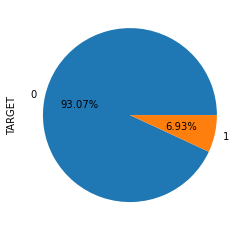

In [8]:
df['TARGET'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.show()

In [9]:
df['TARGET'].value_counts()

0    85773
1     6385
Name: TARGET, dtype: int64

In [10]:
X = df.drop('TARGET',axis=1)
y = df['TARGET']

In [11]:
X.shape, y.shape

((92158, 48), (92158,))

## Our reduced Dataset is already Scaled and dummies are also created for categorical columns

<a id="func"></a>
# Functions for Ease of Coding

## a. Function to plot a confusion matrix

In [13]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
                linewidths = 0.1, annot_kws = {'size':25})

    # set the font size of x-axis ticks using 'fontsize'
    plt.xticks(fontsize = 20)

    # set the font size of y-axis ticks using 'fontsize'
    plt.yticks(fontsize = 20)

    # display the plot
    plt.show()

## b. Function to plot a roc_auc_curve 

In [14]:
   
def plot_roc_auc(model, X_test, y_test):

    plt.figure(figsize=(10,6))
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    #model

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve for Loan Defaulter Prediction', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)

## c. Function to Return scaled and dummy for X and y for Model Building

In [15]:
def dataset_processing(df, encoding='ohe',scaling='standard'):
    print("Shape of the Dataset Provided: ", df.shape)
    
    #scaling numeric features
    df_num = df.select_dtypes('number')
    num_cols =df_num.nunique()
    binary_cols = num_cols[num_cols<4].index
    df_num = df_num.drop(binary_cols, axis=1)
    
    if scaling=='minmax':
        
        from sklearn.preprocessing import MinMaxScaler
        
        mm = MinMaxScaler(feature_range = (0, 1))
        scaled = mm.fit_transform(df_num)
        
        df_scaled = pd.DataFrame(scaled, columns=df_num.columns)
        print("MinaMax Scaling Done...")
        
    elif scaling=='standard':
        df_scaled = (df_num - df_num.mean())/df_num.std()
        print("Standard Scaling Done...")
    
    elif scaling=='no':
        # not applying scaling
        df_scaled = df_num
        print("Not applying Scaling...")
        
    # Catch error if scaling scheme is not valid
    else:
        raise ValueError("Scaling must be either 'minmax' or 'standard' or 'no'")
        
        
    #creating dummies:
    df_cat = df.select_dtypes('object')
    
    if encoding=='ohe':
        df_cat = pd.get_dummies(df_cat, drop_first=True)
        print('Dummies Created...')
        
    # Integer label encoding
    elif encoding == 'le':
        
        from sklearn.preprocessing import LabelEncoder
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # Iterate through each column
        for col in df_cat.columns:
            df_cat[col] = label_encoder.fit_transform(np.array(df_cat[col].astype(str)).reshape((-1,)))
        
        print("Label Encoding Done...")
                
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
        
    df_final = pd.concat([df_scaled, df_cat],axis=1,join='inner')
    df_final = pd.concat([df[binary_cols], df_final], axis=1, join='inner')
    
    print("Processed Datset Shape: ", df_final.shape)
    
    X = df_final.drop('TARGET',axis=1)
    y = df_final['TARGET']
    
    return X, y

## d. Model Building Pipeline Function (latest version)

In [16]:
def build_model_pipeline(model_name, X,y, plot_graphs=False,feature_importance = False,over_sampling=False):
    
    # For over sampling
    if over_sampling==True:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
        print('Over Sampling Done using SMOTE')
    
    
    X_train,X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=10)
    print('Train Test Split Done...')

    #X_train.shape , X_test.shape, y_train.shape, y_test.shape
    
    model = model_name

    model.fit(X_train,y_train)
    print('Model Fitted...')

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    if plot_graphs == True:
        
        print(classification_report(y_train, y_pred_train))
        
        print(classification_report(y_test, y_pred_test))
        
        plot_confusion_matrix(model, X_test, y_test)
        
        plot_roc_auc(model, X_test, y_test)
    else:
        print(classification_report(y_train, y_pred_train))
        print(classification_report(y_test, y_pred_test))
    
    # saving performance metrics for the mode
    
    eval_metrics = [accuracy_score(y_test, y_pred_test), recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test), roc_auc_score(y_test, y_pred_prob)]
    
    if feature_importance == True:
        important_features = pd.DataFrame({'Features': X_train.columns, 
                                       'Importance': model.feature_importances_})
        # sort the dataframe in the descending order according to the feature importance
        
        df_feature_importance = important_features.sort_values('Importance', ascending = False)

        return df_feature_importance, eval_metrics
    
    else: 
        return eval_metrics

## e. Dataframes for saving various combination of Model Scores

In [17]:
# for saving result of models

model_scores = pd.DataFrame(columns=['Accuracy_score', 'Recall_score','F1_score', 'ROC_AUC_Score'])
smote_model_scores = pd.DataFrame(columns=['Accuracy_score','Recall_score' ,'F1_score', 'ROC_AUC_Score'])

## g. Function to Plot Feature Importance

In [18]:
def plot_feature_importance(df):
    plt.figure(figsize=(10,6))
    
    # create a barplot to visualize the features based on their importance
    sns.barplot(x = 'Importance', y = 'Features', data = df.head(15))

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('Top 15 Important Features', fontsize = 15)
    plt.xlabel('Importance', fontsize = 12)
    plt.ylabel('Features', fontsize = 12)

    # display the plot
    plt.show()

<a id='reduced'></a>
# [10. Fitting Models on Final Dataset 2](#home)

<a id='logreg'></a>
## 10.1 Logistic Regression Final Model

Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     68634
           1       0.45      0.01      0.01      5092

    accuracy                           0.93     73726
   macro avg       0.69      0.50      0.49     73726
weighted avg       0.90      0.93      0.90     73726

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17139
           1       0.72      0.01      0.03      1293

    accuracy                           0.93     18432
   macro avg       0.83      0.51      0.50     18432
weighted avg       0.92      0.93      0.90     18432



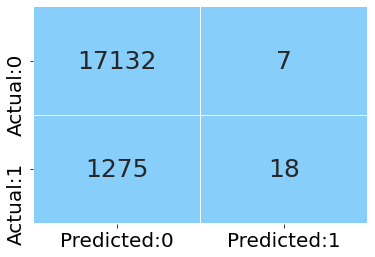

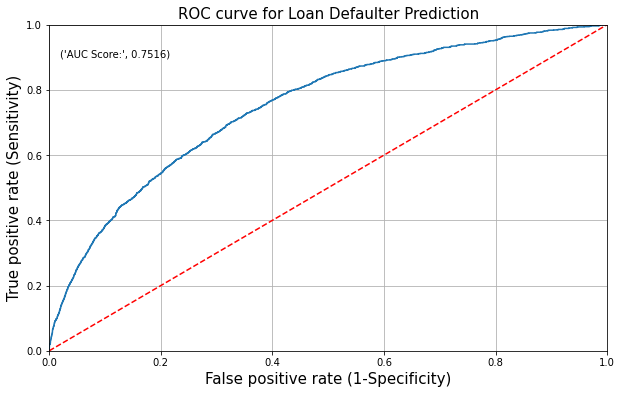

In [19]:
model_scores.loc['LR_Final_Model'] = build_model_pipeline(LogisticRegression(), X,y,plot_graphs=True)

<a id='dt'></a>
## 10.2 Decision Tree Final Model

Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     68634
           1       0.88      0.14      0.24      5092

    accuracy                           0.94     73726
   macro avg       0.91      0.57      0.60     73726
weighted avg       0.94      0.94      0.92     73726

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     17139
           1       0.24      0.04      0.06      1293

    accuracy                           0.92     18432
   macro avg       0.59      0.51      0.51     18432
weighted avg       0.88      0.92      0.90     18432



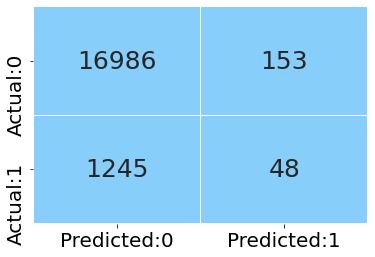

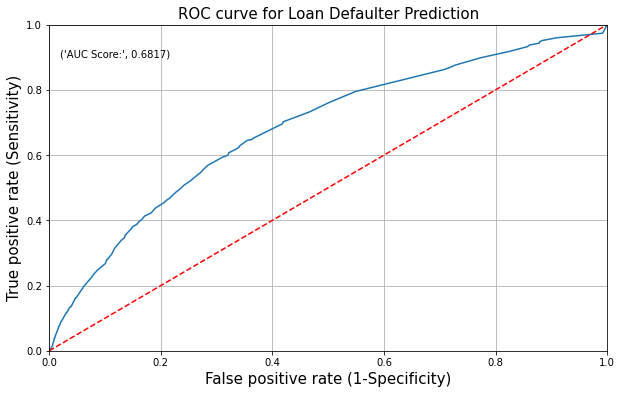

In [20]:
model_scores.loc['DT_Final_Model'] = build_model_pipeline(DecisionTreeClassifier(max_depth=10), X,y,plot_graphs=True)

<a id='rf'></a>
## 10.3 RandomForrest Final Model

Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     68634
           1       1.00      0.00      0.01      5092

    accuracy                           0.93     73726
   macro avg       0.97      0.50      0.49     73726
weighted avg       0.94      0.93      0.90     73726

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17139
           1       0.00      0.00      0.00      1293

    accuracy                           0.93     18432
   macro avg       0.46      0.50      0.48     18432
weighted avg       0.86      0.93      0.90     18432



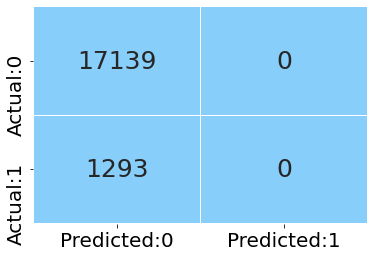

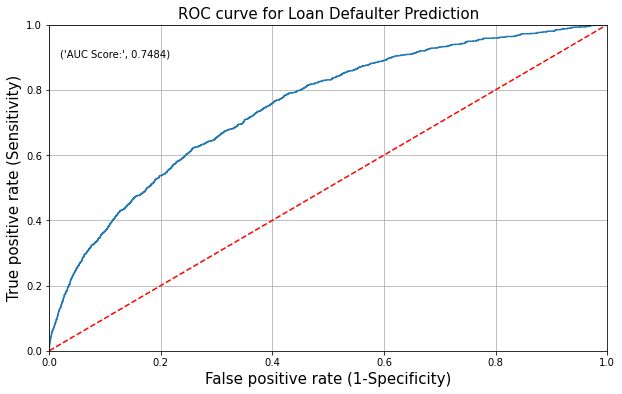

In [23]:
model_scores.loc['RF_Final_Model'] = build_model_pipeline(RandomForestClassifier(max_depth=10), X,y,plot_graphs=True)

<a id='xgb'></a>
## 10.4 XGBoost Reduced Model

Train Test Split Done...
[20:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Fitted...
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     68634
           1       0.97      0.24      0.38      5092

    accuracy                           0.95     73726
   macro avg       0.96      0.62      0.68     73726
weighted avg       0.95      0.95      0.93     73726

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17139
           1       0.46      0.04      0.07      1293

    accuracy                           0.93     18432
   macro avg       0.70      0.52      0.52     18432
weighted avg       0.90      0.93      0.90     18

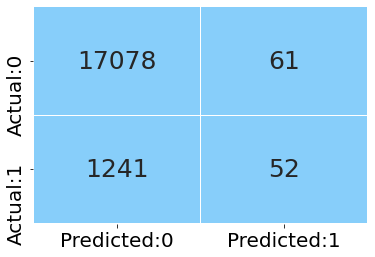

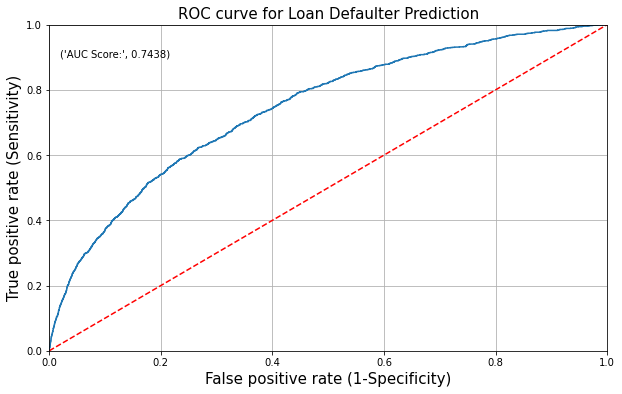

In [24]:
model_scores.loc['XGB_Final_Model'] = build_model_pipeline(XGBClassifier(), X,y,plot_graphs=True)

<a id='lgb'></a>
## 10.5 LightGradientBoost Reduced Model

In [25]:
lgb = LGBMClassifier()

Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     68634
           1       0.93      0.06      0.12      5092

    accuracy                           0.93     73726
   macro avg       0.93      0.53      0.54     73726
weighted avg       0.93      0.93      0.91     73726

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17139
           1       0.57      0.02      0.04      1293

    accuracy                           0.93     18432
   macro avg       0.75      0.51      0.50     18432
weighted avg       0.91      0.93      0.90     18432



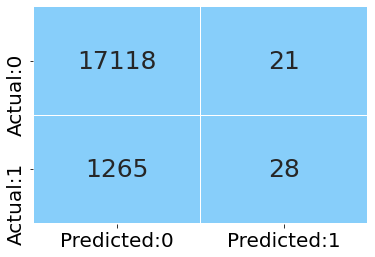

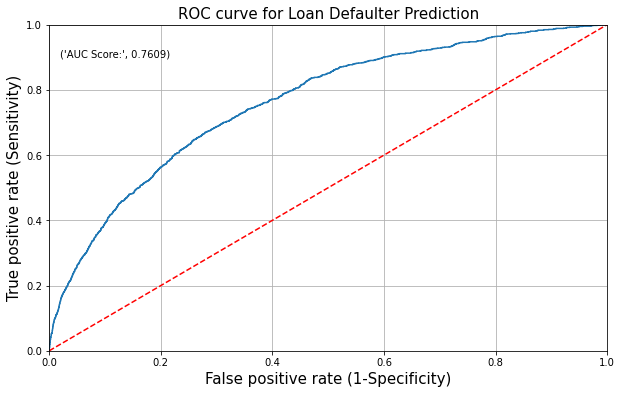

In [26]:
model_scores.loc['LGB_Final_Model'] = build_model_pipeline(lgb, X,y,plot_graphs=True)

<a id='summary'></a>
## [10.6 Final Models Performance Summary](#home)

In [27]:
model_scores

,Accuracy_score,Recall_score,F1_score,ROC_AUC_Score
LR_Final_Model,0.930447,0.013921,0.027314,0.751624
DT_Final_Model,0.924154,0.037123,0.064257,0.681667
RF_Final_Model,0.929850,0.000000,0.000000,0.748417
XGB_Final_Model,0.929362,0.040217,0.073969,0.743754
LGB_Final_Model,0.930230,0.021655,0.041729,0.760927


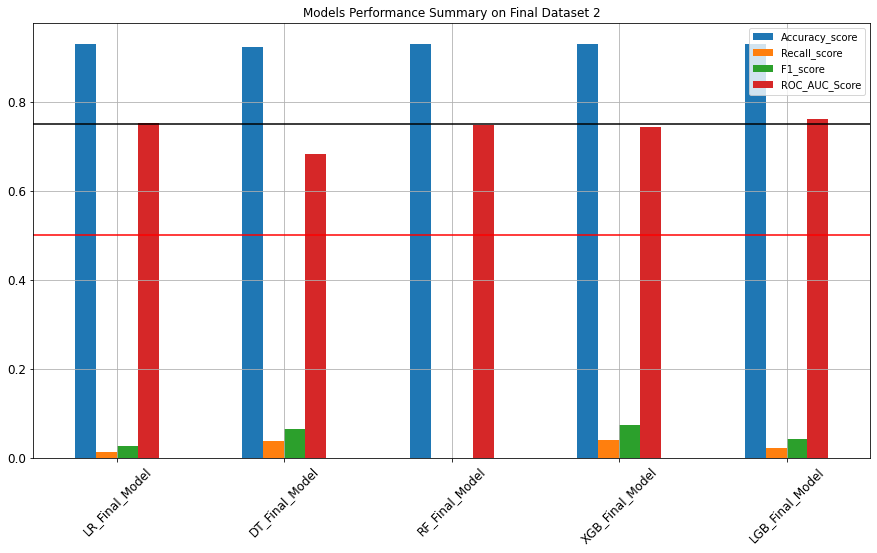

In [28]:
model_scores.plot(kind='bar', figsize=(15,8), title="Models Performance Summary on Final Dataset 2",fontsize=12)
plt.grid()
plt.axhline(0.75, color='black')
plt.axhline(0.5,color='r')
plt.xticks(rotation='45')
plt.show()

In [167]:
# saving the results of reduced_model_scores 

model_scores.to_csv('reduced_model_scores_dataset1.csv')

**Inference:**

- The LGB Model is still having the best AUC Score.
- However, XGBModel has again a better Recall and F1 and almost similar AUC_score.
- Hence, going with XGB Model for building final SMOTE model with 48 features and further, we wil use XGBModel for Hyperparameter Tuning as well.
- **For next part, we will use LGBModel for Kfold Cross validation results, since, LGB is the computationally fastest.**


<a id='kfold'></a>
# [11. Using Stratified KFold Sampling To Increase Performance](#home)

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [30]:
import gc
import time

In [31]:
X.shape, y.shape

((92158, 48), (92158,))

## 11.1 LGBMClassifier Model Evaluation With KFold

In [33]:
def kfold_lightgbm(X,y, num_folds=10, stratified = False, debug= False):
    
    print("Starting LightGBM. X shape: {}, y shape: {}".format(X.shape, y.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(X.shape[0])
    feature_importance_df = pd.DataFrame()
    folds_list = []
    roc_auc_score_list = []
    feats = X.columns
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X[feats], y)):
        train_x, train_y = X[feats].iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = X[feats].iloc[valid_idx], y.iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        folds_list.append(n_fold+1)
        roc_auc_score_list.append(roc_auc_score(valid_y, oof_preds[valid_idx]))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))
    df_roc_auc_score = pd.DataFrame({'Folds': folds_list, 
                                    'ROC_AUC_Score': roc_auc_score_list})
    # Write submission file and plot feature importance
    
    return feature_importance_df, df_roc_auc_score, oof_preds

In [40]:
# Display/plot feature importance from 10 fold Cv of LGBM model

def display_importances(feature_importance_df_):
    
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:25].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(9, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Top 25 Features (avg over folds)',fontsize=15)
    plt.xlabel('Importance',fontsize=12)
    plt.ylabel('Features',fontsize=12)
    plt.tight_layout()
    plt.savefig('lgbm_importances02.png')
    plt.show()

In [35]:
t0 = time.time()

feat_importance, df_roc_auc_score, oof_preds = kfold_lightgbm(X,y, num_folds= 10, stratified= False, debug= False)

print("Total Runtime for LightGBM with 10 fold is: ", time.time()-t0 ,'seconds')

Starting LightGBM. X shape: (92158, 48), y shape: (92158,)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.810707	training's binary_logloss: 0.209039	valid_1's auc: 0.754147	valid_1's binary_logloss: 0.215682
[400]	training's auc: 0.840996	training's binary_logloss: 0.19787	valid_1's auc: 0.763313	valid_1's binary_logloss: 0.213448
[600]	training's auc: 0.863378	training's binary_logloss: 0.189591	valid_1's auc: 0.765711	valid_1's binary_logloss: 0.212914
[800]	training's auc: 0.881315	training's binary_logloss: 0.182639	valid_1's auc: 0.766072	valid_1's binary_logloss: 0.2129
Early stopping, best iteration is:
[648]	training's auc: 0.868049	training's binary_logloss: 0.187821	valid_1's auc: 0.766158	valid_1's binary_logloss: 0.212807
Fold  1 AUC : 0.766158
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored

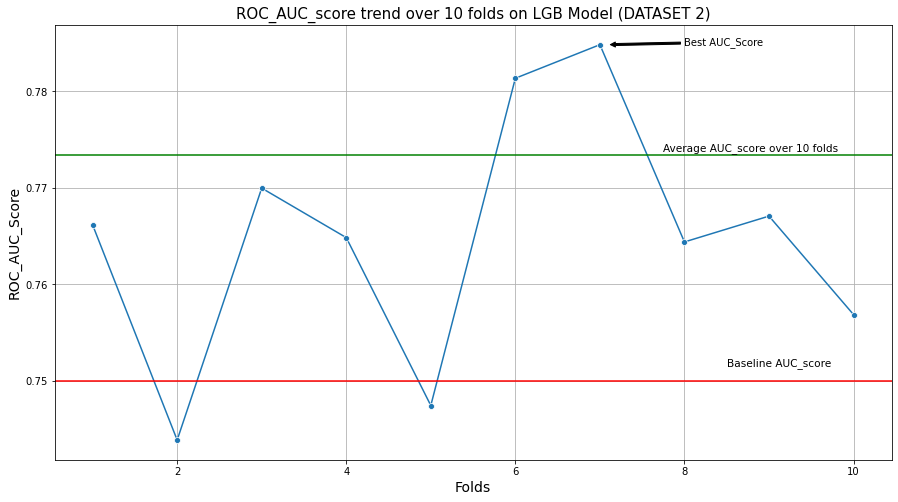

In [38]:
plt.figure(figsize=(15,8))

plt.title("ROC_AUC_score trend over 10 folds on LGB Model (DATASET 2)",fontsize=15)

sns.lineplot(y=df_roc_auc_score['ROC_AUC_Score'], x=df_roc_auc_score['Folds'], marker='o')

# labels
plt.xlabel("Folds",fontsize=14)
plt.ylabel("ROC_AUC_Score",fontsize=14)
plt.axhline(0.773444,color='g')
plt.axhline(0.75,color='r')

# annotations
plt.annotate(s = 'Baseline AUC_score', xy = (3.5, 0.7515), xytext = (8.5, 0.7515),fontsize=10.5)
plt.annotate(s = 'Average AUC_score over 10 folds', xy = (1.5, 0.773444), xytext = (7.75, 0.7738),fontsize=10.5)
plt.annotate(s = 'Best AUC_Score', xy = (7.1, 0.784848), xytext = (8, 0.784848), 
             arrowprops = dict(facecolor = 'black', arrowstyle = 'simple'))

plt.grid()
plt.show()

In [37]:
print("Best score from 10 folds is:  %.6f"% max(df_roc_auc_score['ROC_AUC_Score']))
print('Mean score from 10 folds is: %.6f' % df_roc_auc_score['ROC_AUC_Score'].mean())

Best score from 10 folds is:  0.784848
Mean score from 10 folds is: 0.764679


## Feature Importance from 10Fold Cross Validation of LightGBM classifier (DATASET 2)

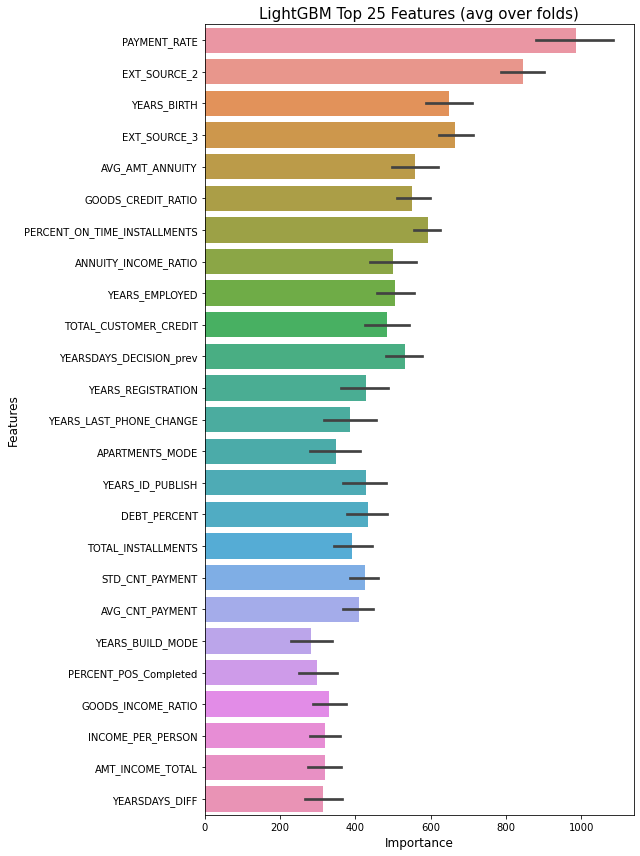

In [41]:
display_importances(feat_importance)

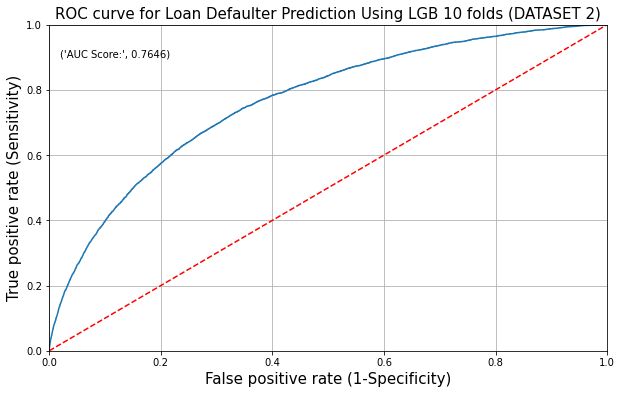

In [42]:
plt.figure(figsize=(10,6))

# the roc_curve() returns the values for false positive rate, true positive rate and threshold
fpr, tpr, thresholds = roc_curve(y, oof_preds)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Loan Defaulter Prediction Using LGB 10 folds (DATASET 2)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y, oof_preds),4)))

# plot the grid
plt.grid(True)

### Not Much improvement.However, the best AUC_score is something to notice

<a id='smote'></a>
# [12. Using SMOTE To Increase Performance](#home)

### Distribution of `Target` Before applying SMOTE

0    85773
1     6385
Name: TARGET, dtype: int64


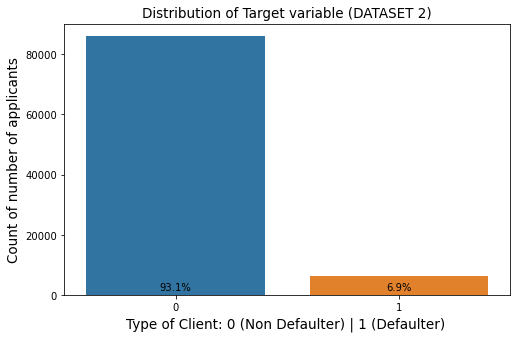

In [46]:
plt.figure(figsize=(8,5))

print(y.value_counts())
ax = sns.countplot(y)
height = list(round(y.value_counts(normalize=True),4)*100)

for p,h in zip(ax.patches, height):
    ax.annotate('{:.1f}%'.format(h),
      xy=(p.get_x() + p.get_width() / 2,h),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
plt.title('Distribution of Target variable (DATASET 2)', fontsize = 13.5)
plt.ylabel('Count of number of applicants', fontsize = 13.5)
plt.xlabel('Type of Client: 0 (Non Defaulter) | 1 (Defaulter) ', fontsize = 13.5)

plt.show()

### Distribution of `Target` After applying SMOTE

In [44]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

0    85773
1    85773
Name: TARGET, dtype: int64


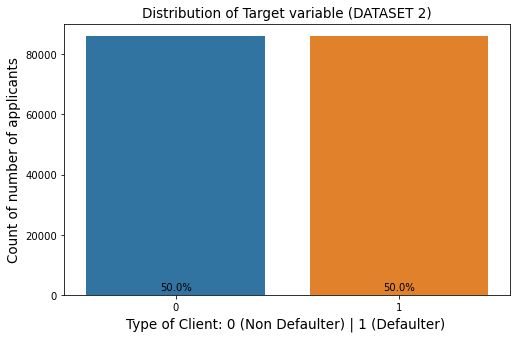

In [47]:
plt.figure(figsize=(8,5))

print(y_smote.value_counts())
ax = sns.countplot(y_smote)
height = list(round(y_smote.value_counts(normalize=True),4)*100)

for p,h in zip(ax.patches, height):
    ax.annotate('{:.1f}%'.format(h),
      xy=(p.get_x() + p.get_width() / 2,h),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
plt.title('Distribution of Target variable (DATASET 2)', fontsize = 13.5)
plt.ylabel('Count of number of applicants', fontsize = 13.5)
plt.xlabel('Type of Client: 0 (Non Defaulter) | 1 (Defaulter) ', fontsize = 13.5)

plt.show()

## 12.1 Logistic regression with SMOTE

Over Sampling Done using SMOTE
Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     68544
           1       0.70      0.70      0.70     68692

    accuracy                           0.70    137236
   macro avg       0.70      0.70      0.70    137236
weighted avg       0.70      0.70      0.70    137236

              precision    recall  f1-score   support

           0       0.71      0.70      0.70     17229
           1       0.70      0.71      0.70     17081

    accuracy                           0.70     34310
   macro avg       0.70      0.70      0.70     34310
weighted avg       0.70      0.70      0.70     34310



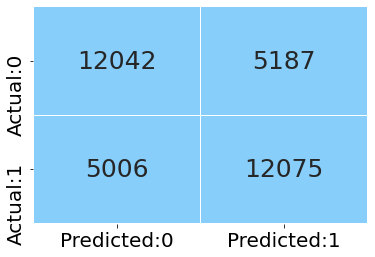

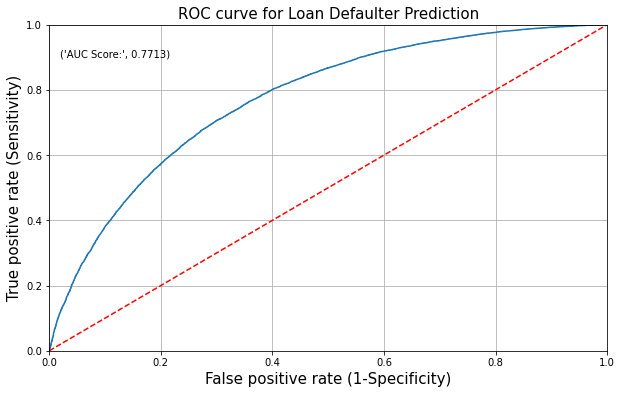

In [48]:
smote_model_scores.loc['LR_Final_Model(SMOTE)'] = build_model_pipeline(LogisticRegression(), 
                                                                   X,y,plot_graphs=True,over_sampling=True)

## 12.2 Decision Tree Reduced Model with SMOTE

Over Sampling Done using SMOTE
Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     68544
           1       0.81      0.79      0.80     68692

    accuracy                           0.81    137236
   macro avg       0.81      0.81      0.81    137236
weighted avg       0.81      0.81      0.81    137236

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     17229
           1       0.80      0.78      0.79     17081

    accuracy                           0.79     34310
   macro avg       0.79      0.79      0.79     34310
weighted avg       0.79      0.79      0.79     34310



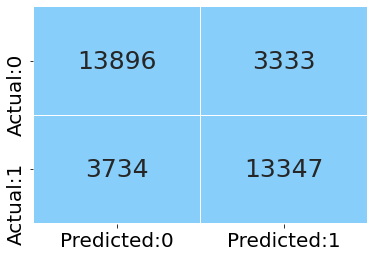

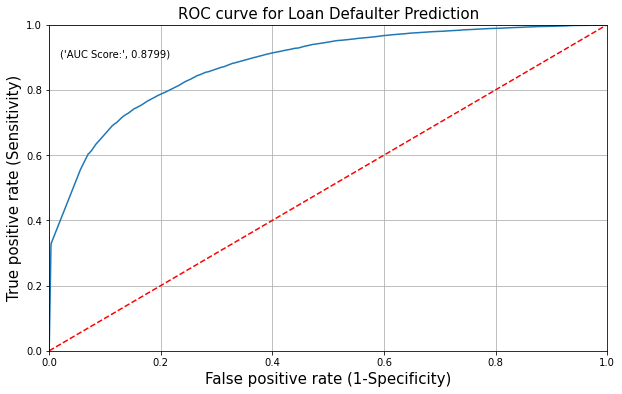

In [49]:
smote_model_scores.loc['DT_Final_Model(SMOTE)'] = build_model_pipeline(DecisionTreeClassifier(max_depth=10), 
                                                                   X,y,plot_graphs=True,over_sampling=True)

## 12.4 RandomForrest Reduced Model with SMOTE

Over Sampling Done using SMOTE
Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.91      0.86      0.89     68544
           1       0.87      0.91      0.89     68692

    accuracy                           0.89    137236
   macro avg       0.89      0.89      0.89    137236
weighted avg       0.89      0.89      0.89    137236

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     17229
           1       0.86      0.90      0.88     17081

    accuracy                           0.88     34310
   macro avg       0.88      0.88      0.88     34310
weighted avg       0.88      0.88      0.88     34310



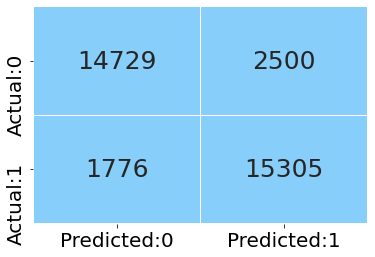

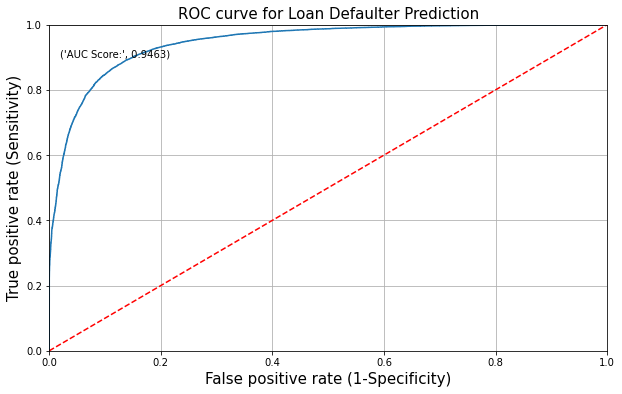

In [50]:
rf_feat_imp_smote, smote_model_scores.loc['RF_Final_Model(SMOTE)'] = build_model_pipeline(RandomForestClassifier(max_depth=10),
                                                                                            X,y,plot_graphs=True,over_sampling=True,
                                                                                            feature_importance=True)

## 12.5 XGBoost Final Model with SMOTE

Over Sampling Done using SMOTE
Train Test Split Done...
[21:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Fitted...
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     68544
           1       1.00      0.94      0.97     68692

    accuracy                           0.97    137236
   macro avg       0.97      0.97      0.97    137236
weighted avg       0.97      0.97      0.97    137236

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     17229
           1       0.99      0.93      0.96     17081

    accuracy                           0.96     34310
   macro avg       0.96      0.96      0.96     34310
weighted avg       

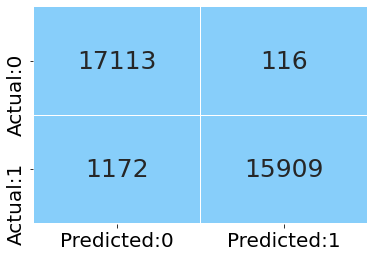

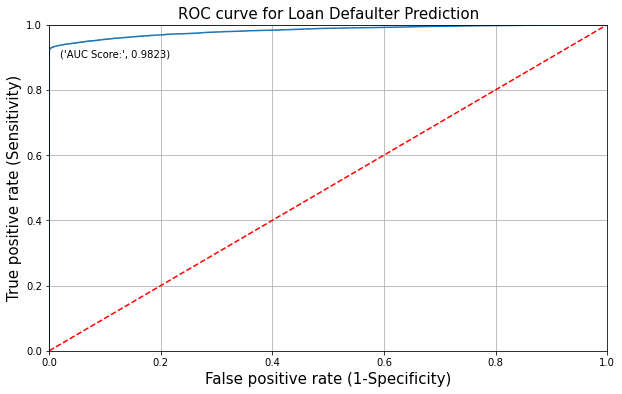

In [51]:
xgb_feat_imp_smote, smote_model_scores.loc['XGB_Final_Model(SMOTE)'] = build_model_pipeline(XGBClassifier(), 
                                                                   X,y,plot_graphs=True,over_sampling=True,
                                                                                             feature_importance=True)

## 12.6 LightGradientBoost Reduced Model with SMOTE

Over Sampling Done using SMOTE
Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     68544
           1       1.00      0.93      0.96     68692

    accuracy                           0.96    137236
   macro avg       0.96      0.96      0.96    137236
weighted avg       0.96      0.96      0.96    137236

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17229
           1       1.00      0.93      0.96     17081

    accuracy                           0.96     34310
   macro avg       0.96      0.96      0.96     34310
weighted avg       0.96      0.96      0.96     34310



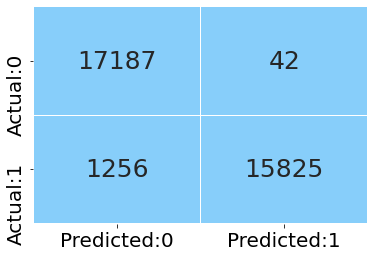

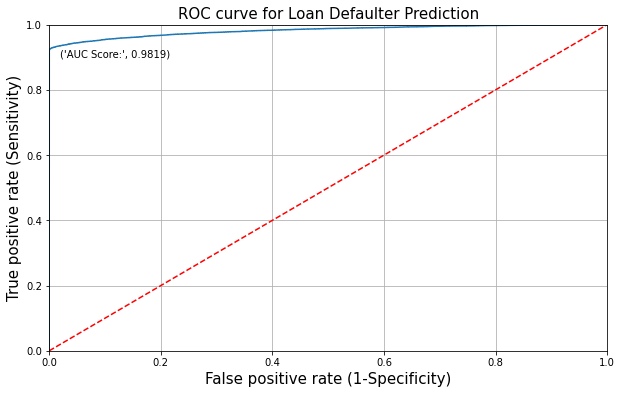

In [52]:
lgb_feat_imp_smote, smote_model_scores.loc['LGBM_Final_Model(SMOTE)'] = build_model_pipeline(lgb,X,y,plot_graphs=True,
                                                                                               over_sampling=True,
                                                                                               feature_importance=True)

## [12.7 Performance Summary of Reduced Models with SMOTE](#home)

In [53]:
smote_model_scores

,Accuracy_score,Recall_score,F1_score,ROC_AUC_Score
LR_Final_Model(SMOTE),0.702915,0.706926,0.703200,0.771321
DT_Final_Model(SMOTE),0.794025,0.781395,0.790676,0.879862
RF_Final_Model(SMOTE),0.875372,0.896025,0.877429,0.946347
XGB_Final_Model(SMOTE),0.962460,0.931386,0.961095,0.982283
LGBM_Final_Model(SMOTE),0.962168,0.926468,0.960605,0.981863


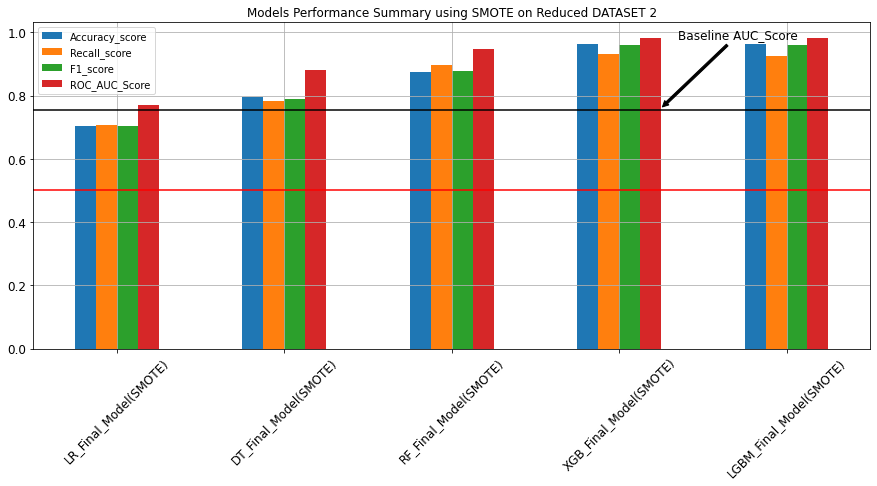

In [55]:
smote_model_scores.plot(kind='bar', figsize=(15,6) ,title="Models Performance Summary using SMOTE on Reduced DATASET 2",fontsize=12)
plt.grid()
plt.axhline(0.753028, color='black')
plt.axhline(0.5,color='r')
plt.xticks(rotation='45')

# annotations
plt.annotate(s = 'Baseline AUC_Score', xy = (3.25, 0.7599), xytext = (3.35, 0.98), 
             arrowprops = dict(facecolor = 'black', arrowstyle = 'simple'),fontsize=12)

plt.show()

In [168]:
# saving the performance of Smote Models in a csv file

smote_model_scores.to_csv('smote_model_scores_dataset1.csv')

<a id = 'feat_imp'></a>
# [13. Feature Importance from Best Model: XGB Classifier](#home)

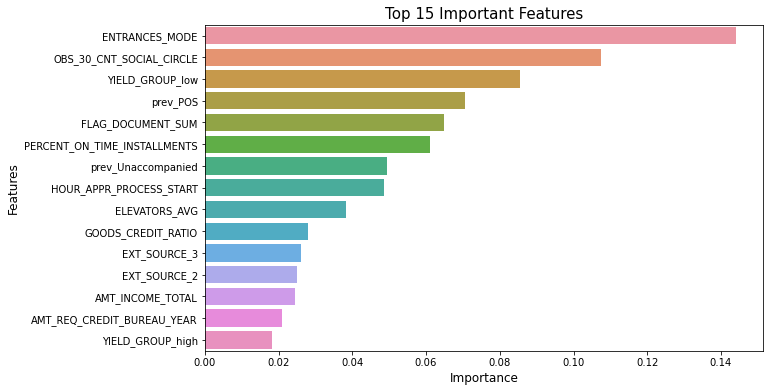

In [56]:
plot_feature_importance(xgb_feat_imp_smote)

<a id = 'tuning'></a>
# [14. Hyperparameter Tuning for the Best Model: XGB Classifier](#home)

In [57]:
tuned_paramaters= [{"learning_rate"    : [ 0.10, 0.15],
                    "max_depth"        : [ 10,20],
                    "min_child_weight" : [ 1, 3, ],
                    "gamma"            : [ 0.0,0.2],
                    "colsample_bytree" : [ 0.3,0.5 ] }]

In [58]:
xgb_model = XGBClassifier()

In [59]:
xgb_random = RandomizedSearchCV(estimator =xgb_model, 
                                param_distributions= tuned_paramaters,
                                verbose=True, 
                                cv = 3,
                                n_iter=10)

In [60]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)


In [61]:
X_train,X_test, y_train, y_test=train_test_split(X_smote,y_smote,test_size=0.2,random_state=10)

In [62]:
t0 = time.time()

xgb_tuned_model = xgb_random.fit(X_train, y_train)

print("Total Runtime for XGB Classifier Hyperparameter with 3 fold Random CV is: ", time.time()-t0 ,'seconds')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[21:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:17

[21:12:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:12:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [63]:
# get the best parameters
print('Best parameters for XGB classifier: ', xgb_tuned_model.best_params_, '\n')

Best parameters for XGB classifier:  {'min_child_weight': 1, 'max_depth': 20, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.5} 



## Building Final Tuned model on the best parameters obtained from Hyperparameter Tuning  

In [64]:
xgb_final_model = XGBClassifier(min_child_weight=1, 
                                max_depth= 20, 
                                learning_rate=0.15, 
                                gamma= 0.0,
                                colsample_bytree=0.5)

Over Sampling Done using SMOTE
Train Test Split Done...
[21:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Fitted...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68544
           1       1.00      1.00      1.00     68692

    accuracy                           1.00    137236
   macro avg       1.00      1.00      1.00    137236
weighted avg       1.00      1.00      1.00    137236

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17229
           1       1.00      0.93      0.97     17081

    accuracy                           0.97     34310
   macro avg       0.97      0.97      0.97     34310
weighted avg       

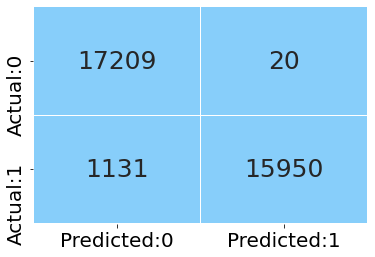

ValueError: Must have equal len keys and value when setting with an iterable

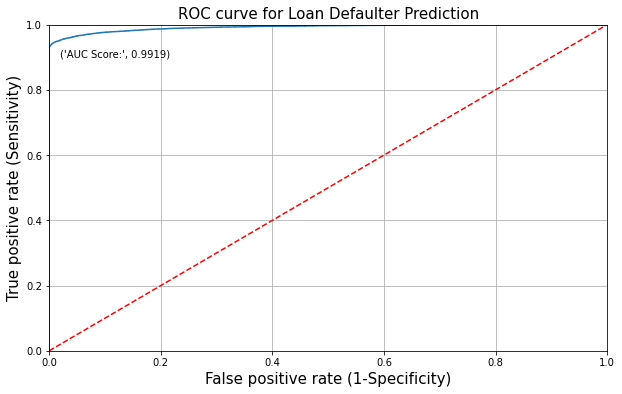

In [70]:
final_feat_imp = smote_model_scores.loc['XGB_Final_Tuned_Model'] = build_model_pipeline(xgb_final_model,
                                            X,y,plot_graphs=True,over_sampling=True,
                                                                      feature_importance=True)

In [66]:
smote_model_scores

,Accuracy_score,Recall_score,F1_score,ROC_AUC_Score
LR_Final_Model(SMOTE),0.702915,0.706926,0.703200,0.771321
DT_Final_Model(SMOTE),0.794025,0.781395,0.790676,0.879862
RF_Final_Model(SMOTE),0.875372,0.896025,0.877429,0.946347
XGB_Final_Model(SMOTE),0.962460,0.931386,0.961095,0.982283
LGBM_Final_Model(SMOTE),0.962168,0.926468,0.960605,0.981863
XGB_Final_Tuned_Model,0.965899,0.932732,0.964582,0.991757


# [15. Summary of the XGBoost Tuned Model](#home)

In [67]:
smote_model_scores.loc[['XGB_Final_Model(SMOTE)','XGB_Final_Tuned_Model']]

,Accuracy_score,Recall_score,F1_score,ROC_AUC_Score
XGB_Final_Model(SMOTE),0.962460,0.931386,0.961095,0.982283
XGB_Final_Tuned_Model,0.965899,0.932732,0.964582,0.991757


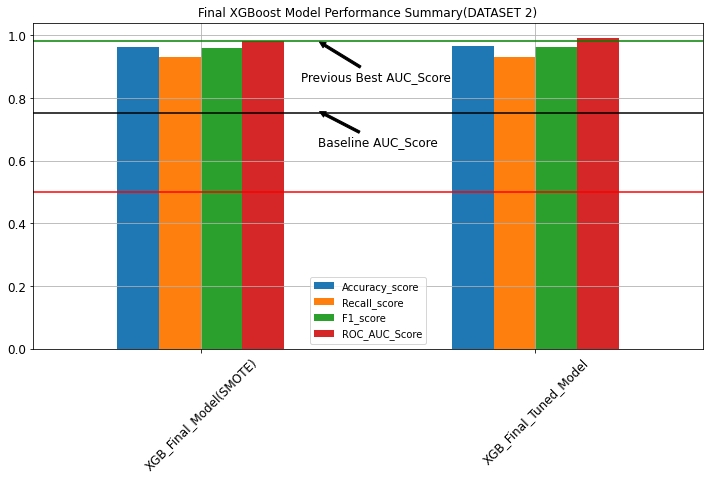

In [69]:
#smote_model_scores

smote_model_scores.loc[['XGB_Final_Model(SMOTE)','XGB_Final_Tuned_Model']].plot(kind='bar', figsize=(12,6) ,
                                                                                title="Final XGBoost Model Performance Summary(DATASET 2)",fontsize=12)
plt.grid()
plt.axhline(0.753028, color='black')
plt.axhline(0.5,color='r')
plt.axhline(0.982283,color='g')

plt.xticks(rotation='45')

# annotations
plt.annotate(s = 'Baseline AUC_Score', xy = (0.35, 0.7599), xytext = (0.35, 0.65), 
             arrowprops = dict(facecolor = 'black', arrowstyle = 'simple'),fontsize=12)
plt.annotate(s = 'Previous Best AUC_Score', xy = (0.35, 0.982283), xytext = (0.30, 0.85757), 
             arrowprops = dict(facecolor = 'black', arrowstyle = 'simple'),fontsize=12)


plt.show()

**Inference:**
- The positive impact of Hyperparameter Tuning is clearly noticeable above.
- All the metrics including Recall_score and F1_score are increased by approx. 1 %.
- We can see below the chart for comparison of Final `XGBoost Model` before and after tuning it.
- The Green line is the line for AUC_score obtained from SMOTE.
- This is a positive outcome of all the hardowork and efforts put into the Data Processing and Preparation.


## Plotting Final Feature Importance:

In [71]:
plot_feature_importance(final_feat_imp)

AttributeError: 'tuple' object has no attribute 'head'

<Figure size 720x432 with 0 Axes>